<a href="https://colab.research.google.com/github/KANGladiator/Feynn_labs_project-3/blob/main/flowmag_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Run this cell for downloading {display-mode: "form"}

# install packages
!pip install omegaconf > /dev/null 2>&1
!pip install einops > /dev/null 2>&1

# download code and checkpoint
!git clone https://github.com/dangeng/flowmag > /dev/null 2>&1
%cd flowmag
!gdown 1ESSaea-Roe1feFugPFycW5Dd7QCg2ZXR -O checkpoints/raft_chkpt_00140.pth > /dev/null 2>&1


# prepare for generating mask
!git clone https://github.com/facebookresearch/segment-anything > /dev/null 2>&1
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.15.0 > /dev/null 2>&1


!mkdir segment-anything/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O segment-anything/weights/sam_vit_h_4b8939.pth > /dev/null 2>&1


/content/flowmag


In [ ]:
# @title Run this cell for setup {display-mode: "form"}

# imports for flowmag
import os
import torch
import glob
import shutil
import argparse
from pathlib import Path
from omegaconf import OmegaConf

from google.colab import files
from IPython.display import HTML
from base64 import b64encode

from inference import inference
from myutils import get_our_model, dist_transform
from dataset import FramesDataset


class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def upload_file():
    uploaded = files.upload()
    try:
        input_video = list(uploaded.keys())[0]
    except:
        print ("Please upload a valid image file!")
        raise StopExecution
    print(f"Uploaded file {input_video} of {len(uploaded[input_video])} bytes")
    return input_video

def prepare_inference(frames_dir, save_name):
    frames_dataset = FramesDataset(frames_dir)

    # Make save dir
    save_dir = Path("./inference") / save_name
    save_dir.mkdir(exist_ok=True, parents=True)
    return save_dir, frames_dataset

def prepare_mask(mask_path, soft_mask):
    # Load mask from npy file
    mask = np.load(mask_path)
    mask = torch.tensor(mask)
    h, w = mask.shape
    mask = mask.float()

    if soft_mask:
        print("Softening mask")
        dist = dist_transform(mask)
        dist[dist < soft_mask] = 1
        dist[dist >= soft_mask] = 0
        mask = dist
    return mask

parser = argparse.ArgumentParser(description="config and checkpoint.")
parser.add_argument("--config", type=str, default="./configs/alpha16.color10.yaml")
parser.add_argument('--resume', type=str, default="./checkpoints/raft_chkpt_00140.pth")
parser.add_argument('-f')
args = parser.parse_args()

# Make model
model, epoch = get_our_model(args)
config = OmegaConf.load(args.config)
max_alpha = config.train.alpha_high

# imports for sam

import cv2
import sys
import numpy as np
import supervision as sv
import base64
from google.colab import output
from jupyter_bbox_widget import BBoxWidget
from IPython.display import display
from google.colab.patches import cv2_imshow

sys.path.append('segment-anything')
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def on_submit_callback():
    bbox_data = widget.bboxes[0]
    box = widget.bboxes[0]
    box = np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ])

    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    mask_predictor.set_image(image_rgb)

    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )

    print("MASK SAVED")
    np.save(mask_path, (masks[0] | masks[1] | masks[2]))

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

def vis_mask(img_path, mask_path):

    temp_frame = cv2.imread(img_path)
    masks = np.load(mask_path)[None,:,:]
    mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_map="index")

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )

    detections = detections[detections.area == np.max(detections.area)]
    segmented_image = mask_annotator.annotate(scene=temp_frame.copy(), detections=detections)

    return np.concatenate([temp_frame, segmented_image], axis=1)

sam = sam_model_registry["vit_h"](checkpoint="./segment-anything/weights/sam_vit_h_4b8939.pth").cuda()
mask_predictor = SamPredictor(sam)

Making model
Resuming from ./checkpoints/raft_chkpt_00140.pth


In [ ]:
# @title Try our magnification for <i>Butterfly</i> sequence {display-mode: "form"}
# @markdown This example will automatically download the butterfly video and enable you to <b>input the magnification factor (alpha)</b> in command line.
# @markdown * Magnification factor (alpha) is a number that how many times you wish the motion to be magnified. E.g., the default magnification factor for butterfly sequence is 5, and the motion will be magnified by 5 times.
alpha = 5 # @param {type:"number"}

image_folder = "./data/butterfly"
if not os.path.exists(image_folder):
    print("------------------------------")
    print("DOWNLOADING VIDEO")
    input_video = "./data/butterfly.mp4"
    os.system(f"gdown 1Ov2mChaEwuMaHWrceYH-srkc86qp4iw0 -O {input_video}")

    print("------------------------------")
    print("CONVERT TO IMAGES")
    os.mkdir(image_folder)
    os.system(f"ffmpeg -i {input_video} {image_folder}/%04d.png > /dev/null 2>&1")

else:
    print("------------------------------")
    print("FOLDER EXISTED")

print("------------------------------")
print("MAGNIFYING")
save_name = "butterfly.raft.ep140"
save_dir, frames_dataset = prepare_inference(image_folder, save_name)
inference(model, frames_dataset, save_dir, alpha=alpha, max_alpha=max_alpha, output_video=False)

output_video = "./inference/butterfly_comp.mp4"
if os.path.isfile(output_video):
    os.remove(output_video)
generated_folder = glob.glob(f"./inference/{save_name}/x{alpha}*")[0]
os.system(f"ffmpeg -framerate 30 -start_number 1 -i {image_folder}/%04d.png -framerate 30 -start_number 1 -i {generated_folder}/%04d.png -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' -map '[vid]' -c:v libx264 -crf 23 -preset veryfast {output_video} > /dev/null 2>&1")
print(f"The magnified video concatenated with original video is saved at: {output_video}")

video = open(output_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(video).decode()
HTML("""
<div style="text-align: center;">
    <h3>Original Video (Left), Magnified Video (Right, x%s)</h3>
    <video width=1200 autoplay controls muted loop playsinline>
        <source src="%s" type="video/mp4">
    </video>
</div>
""" % (str(alpha), data_url))

------------------------------
DOWNLOADING VIDEO
------------------------------
CONVERT TO IMAGES
------------------------------
MAGNIFYING


100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


saved the images to inference/butterfly.raft.ep140/x5
The magnified video concatenated with original video is saved at: ./inference/butterfly_comp.mp4


In [ ]:
# @title Try our magnification for <i>Cats</i> sequence {display-mode: "form"}
# @markdown This example will automatically download the cats video and enable you to try targeted magnification on one of the cats by assigning different masks.
image_folder = "./data/twocats"
if not os.path.exists(image_folder):
    print("------------------------------")
    print("DOWNLOADING VIDEO")
    input_video = "./data/twocats.mp4"
    os.system(f"gdown 1VEud5KYrt055K_arwE_DrBymmW3npMur -O {input_video}")

    print("------------------------------")
    print("CONVERT TO IMAGES")
    os.mkdir(image_folder)
    os.system(f"ffmpeg -i {input_video} {image_folder}/%04d.png > /dev/null 2>&1")

else:
    print("------------------------------")
    print("FOLDER EXISTED")

print("------------------------------")
# @markdown Choose if you use masks from the dropdown before running this cell.

# @markdown "black cat" option will only magnify the motion of black cat, and "white cat" option will only magnify the motion of white cat. "none" option will magnify the motion of both cats.
use_mask = 'black cat' # @param ["white cat", "black cat", "none"]

print("MAGNIFYING")
alpha = 20 # @param {type:"number"}

save_name = "twocats.raft.ep140"
save_dir, frames_dataset = prepare_inference(image_folder, save_name)
if use_mask == "none":
    inference(model, frames_dataset, save_dir, alpha=alpha, max_alpha=max_alpha, output_video=False)
    generated_folder = glob.glob(f"./inference/{save_name}/x{alpha}*")[0]

elif use_mask == "white cat":
    cat_mask_path = "./data/white_cat_mask.npy"
    cat_mask = prepare_mask(cat_mask_path, soft_mask=25)
    inference(model, frames_dataset, save_dir, alpha=alpha, max_alpha=max_alpha, mask=cat_mask, output_video=False)
    generated_folder = glob.glob(f"./inference/{save_name}/masked_x{alpha}*")[0]

elif use_mask == "black cat":
    cat_mask_path = "./data/black_cat_mask.npy"
    cat_mask = prepare_mask(cat_mask_path, soft_mask=25)
    inference(model, frames_dataset, save_dir, alpha=alpha, max_alpha=max_alpha, mask=cat_mask, output_video=False)
    generated_folder = glob.glob(f"./inference/{save_name}/masked_x{alpha}*")[0]

output_video = "./inference/twocats_comp.mp4"
if os.path.isfile(output_video):
    os.remove(output_video)
os.system(f"ffmpeg -framerate 30 -start_number 1 -i {image_folder}/%04d.png -framerate 30 -start_number 1 -i {generated_folder}/%04d.png -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' -map '[vid]' -c:v libx264 -crf 23 -preset veryfast {output_video} > /dev/null 2>&1")
print(f"The magnified video concatenated with original video is saved at: {output_video}")

video = open(output_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(video).decode()
HTML("""
<div style="text-align: center;">
    <h3>Original Video (Left), Magnified Video (Right, x%s), Mask: %s</h3>
    <video width=1200 autoplay controls muted loop playsinline>
        <source src="%s" type="video/mp4">
    </video>
</div>
""" % (str(alpha), use_mask, data_url))

------------------------------
DOWNLOADING VIDEO
------------------------------
CONVERT TO IMAGES
------------------------------
MAGNIFYING
Softening mask


100%|██████████| 260/260 [01:45<00:00,  2.47it/s]


saved the images to inference/twocats.raft.ep140/masked_x20
The magnified video concatenated with original video is saved at: ./inference/twocats_comp.mp4


In [ ]:
# @title Upload your own video {display-mode: "form"}

# @markdown To avoid the duplicates of uploaded videos, we will remove the previous uploaded video when you run this cell.

try:
    os.remove(input_video)
except:
    pass

print("------------------------------")
print("UPLOAD INPUT FILE")
input_video = upload_file()

print("------------------------------")
print("CONVERT TO IMAGES")
image_folder = "./data/temp"
if os.path.exists(image_folder):
    shutil.rmtree(image_folder)

os.mkdir(image_folder)
os.system(f"ffmpeg -i {input_video} {image_folder}/%04d.png > /dev/null 2>&1")
use_mask = False

------------------------------
UPLOAD INPUT FILE


Saving tuningforks.mp4 to tuningforks.mp4
Uploaded file tuningforks.mp4 of 286170 bytes
------------------------------
CONVERT TO IMAGES


In [ ]:
# @title Generate mask {display-mode: "form"}
# @markdown If you wish to run targeted magnification, check the "use_mask" box before you run this cell, otherwise, please uncheck the box and run the cell.

# @markdown If "use_mask" is True, after running this cell, you will be able to plot and adjust a bounding box for mask generation. <b>Please remeber to click "Submit" when you finish the bounding box!</b>

use_mask = True # @param {type:"boolean"}

if use_mask:
    print("------------------------------")
    print("GET MASK")

    image_path = sorted(glob.glob(os.path.join(image_folder, "*")))[0]
    mask_path = "./data/mask.npy"

    if os.path.isfile(mask_path):
        os.remove(mask_path)

    output.enable_custom_widget_manager()

    widget = BBoxWidget()
    widget.image = encode_image(image_path)
    display(widget)

    widget.on_submit(on_submit_callback)

else:
    print("Not targeted magnification, no mask generated.")

------------------------------
GET MASK


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

MASK SAVED


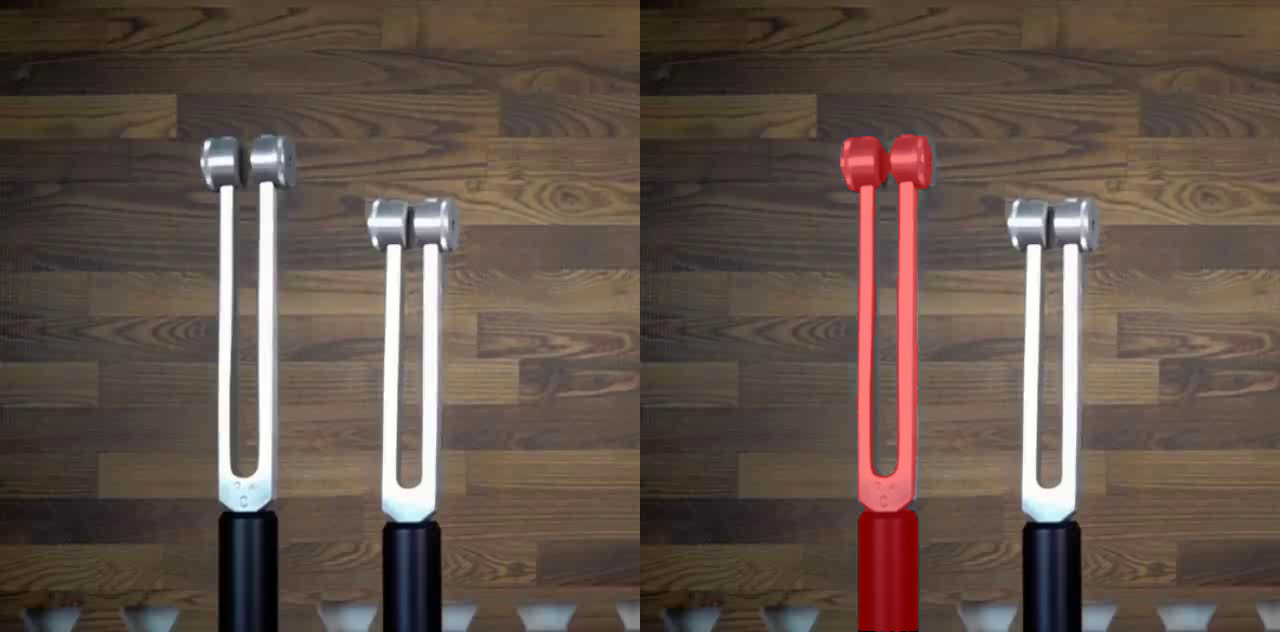

In [ ]:
# @title (Optional) Visualize the mask {display-mode: "form"}
if use_mask:
    temp = vis_mask(sorted(glob.glob(os.path.join(image_folder, '*')))[0], mask_path)
    cv2_imshow(temp)
else:
    print("Not targeted magnification, no mask generated.")
# @markdown If you find the mask unsatifying, please try the "Generate mask" cell again.


In [ ]:
# @title Run magnification { display-mode: "form"}
# @markdown Feel free to try different magnification factors (alpha) by filling the blank with different numbers.

# @markdown <b>Warning</b>: the magnified frames are saved as image files, and a video (displayed below) concatenated both original and magnified frames will be saved as well. If you run the cell for multiple times with different alpha, the concatenated video will be updated with the most recent trial, but the all magnified frames can still be found in different folders. Therefore, if you are satisfied with the result, make sure to download the displayed video before you run this cell for another time, or use `ffmpeg` to generate a video from the folder of magnified frames in the end.
alpha = 5 # @param {type:"number"}
save_name = "temp.raft.ep140"

print("------------------------------")
print("MAGNIFYING")
save_dir, frames_dataset = prepare_inference(image_folder, save_name)

if use_mask:
    mask = prepare_mask(mask_path, soft_mask=25)
    inference(model, frames_dataset, save_dir, alpha=alpha, max_alpha=max_alpha, mask=mask, output_video=False)
    generated_folder = glob.glob(f"./inference/{save_name}/masked_x{alpha}*")[0]
else:
    inference(model, frames_dataset, save_dir, alpha=alpha, max_alpha=max_alpha, output_video=False)
    generated_folder = glob.glob(f"./inference/{save_name}/x{alpha}*")[0]

output_video = "./inference/temp.mp4"
if os.path.isfile(output_video):
    os.remove(output_video)
os.system(f"ffmpeg -framerate 30 -start_number 1 -i {image_folder}/%04d.png -framerate 30 -start_number 1 -i {generated_folder}/%04d.png -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' -map '[vid]' -c:v libx264 -crf 23 -preset veryfast {output_video} > /dev/null 2>&1")
print(f"The magnified video concatenated with original video is saved at: {output_video}")

video = open(output_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(video).decode()
HTML("""
<div style="text-align: center;">
    <h3>Original Video (Left), Magnified Video (Right, x%s)</h3>
    <video width=1200 autoplay controls muted loop playsinline>
        <source src="%s" type="video/mp4">
    </video>
</div>
""" % (str(alpha), data_url))

------------------------------
MAGNIFYING
Softening mask


100%|██████████| 79/79 [00:09<00:00,  8.62it/s]


saved the images to inference/temp.raft.ep140/masked_x5
The magnified video concatenated with original video is saved at: ./inference/temp.mp4
